In [212]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

import pmdarima as pm

#### Problem 1

In [80]:
data = pd.read_csv('../data/CRSPday.csv', usecols=list(range(1, 8)), parse_dates=[[0, 1, 2]], index_col=0)
data.index.name = 'date'
data.head()

,ge,ibm,mobil,crsp
date,,,,
1989-01-03,-0.016760,0.000000,-0.002747,-0.007619
1989-01-04,0.017045,0.005128,0.005510,0.013016
1989-01-05,-0.002793,-0.002041,0.005479,0.002815
1989-01-06,0.000000,-0.006135,0.002725,0.003064
1989-01-09,0.000000,0.004115,0.005435,0.001633


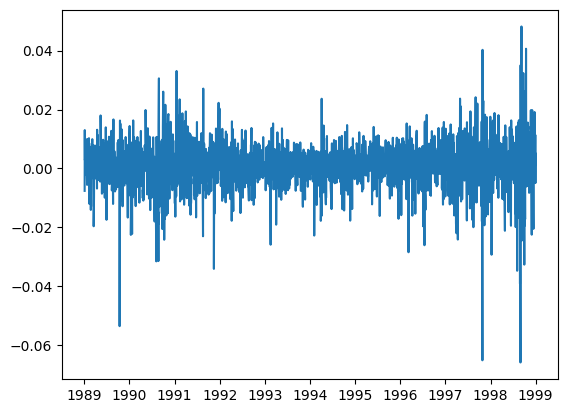

In [81]:
fig, ax = plt.subplots()
ax.plot(data['crsp']);

In [82]:
import statsmodels.graphics.tsaplots as tsaplots

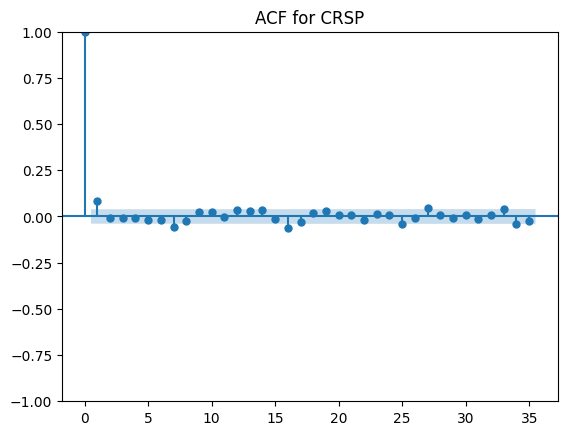

In [83]:
fig, ax = plt.subplots()
tsaplots.plot_acf(data['crsp'], ax=ax);
ax.set_title('ACF for CRSP');

(a) In R, the `acf` function uses the fraction of a year as the lag when passed a time series, hence the first plot would show lags as fractions of a year and the second one - as the number of days.

(b) There is a significant autocorrelation for lag 1. The other autocorrelations that come up as significant might do so by chance - this requires further investigation.

#### Problem 2

In [95]:
# by default, the ARIMA fitter uses a state space model rather than maximising MLE for innovations.
fit1 = sm.tsa.arima.ARIMA(data['crsp'].values, order=(1, 0, 0)).fit(method='innovations_mle')
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2528
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8706.184
Date:                Thu, 06 Apr 2023   AIC                         -17406.367
Time:                        10:16:42   BIC                         -17388.862
Sample:                             0   HQIC                        -17400.016
                               - 2528                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.837      0.000       0.000       0.001
ar.L1          0.0853      0.011      7.781      0.000       0.064       0.107
sigma2      5.973e-05    7.8e-07     76.560      0.000    5.82e-05    6.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6295.58
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can check that we obtain the same results by maximising MLE directly.

In [88]:
from scipy.optimize import minimize

In [89]:
Y = data['crsp']

In [90]:
def loglik_f(params):
    mu = params[0]
    phi = params[1]
    sigma = params[2]
    n = len(Y)
    eps = (Y - mu - phi * (Y.shift() - mu)).dropna()
    return n * np.log(sigma) - 0.5 * np.log(1 - phi ** 2) + (Y[0] - mu) ** 2 * (1 - phi ** 2) / 2 / sigma ** 2 + np.sum(eps ** 2 / 2 / sigma ** 2)

In [91]:
start = np.array([np.mean(Y), 0, np.std(Y, ddof=1)])
lower = np.array([-0.5, -0.99, 0.0001])
upper = np.array([0.5, 0.99, 0.5])

In [96]:
fit_mle = minimize(loglik_f, start, method='L-BFGS-B', bounds=list(zip(lower, upper)))
fit_mle

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -11029.260236454975
        x: [ 6.783e-04  8.530e-02  7.728e-03]
      nit: 8
      jac: [ 5.002e-01  7.276e-03 -5.566e-02]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [97]:
fit2 = sm.tsa.arima.ARIMA(data['crsp'].values, order=(2, 0, 0)).fit(method='innovations_mle')
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2528
Model:                 ARIMA(2, 0, 0)   Log Likelihood                8706.435
Date:                Thu, 06 Apr 2023   AIC                         -17404.870
Time:                        10:16:59   BIC                         -17381.529
Sample:                             0   HQIC                        -17396.401
                               - 2528                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.783      0.000       0.000       0.001
ar.L1          0.0865      0.011      7.665      0.000       0.064       0.109
ar.L2         -0.0141      0.014     -1.001      0.317      -0.042       0.014
sigma2      5.972e-05   8.11e-07     73.617      0.000    5.81e-05    6.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6451.14
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(a) The high p-value for `ar.L2` suggests that the parameter might not be significant. The AIC and BIC are both lower for the ARIMA(1, 0, 0), so the simpler model is preferable.

(b) The 95% confidence intervals for the parameters are:

In [109]:
fit1.conf_int()

array([[3.31791702e-04, 1.02485150e-03],
       [6.38160891e-02, 1.06787836e-01],
       [5.82003566e-05, 6.12585406e-05]])

#### Exercise 3

(a-c)

Let $$Y_t = a + \phi Y_{t-1} + \epsilon_t,$$
where $a=5$, $\phi=-0.55$. Then
$$Y_t = a \sum_{i=0}^{n-1} \phi^i + \phi^n Y_{t-n} + \sum_{i=0}^{n-1} \phi^i \epsilon_{t-i} = a \sum_{i=0}^{t-1} \phi^i + \phi^t Y_0 + \sum_{i=0}^{t-1} \phi^i \epsilon_{t-i},$$
so
$$E[Y_t] = a \sum_{i=0}^{t-1} \phi^i + \phi^t Y_0 = a \frac{1 - \phi^t}{1 - \phi} + \phi^t Y_0$$
and
$$\mathrm{Var}[Y_t] = \mathrm{Var}\left[\sum_{i=0}^{t-1} \phi^i \epsilon_{t-i}\right] = \sigma^2_\epsilon \sum_{i=0}^{t-1} \phi^{2i} = \sigma^2_\epsilon \frac{1 - \phi^{2t}}{1 - \phi^2}.$$

Since both $E[Y_t]$ and $\mathrm{Var}[Y_t]$ depend on $t$, the process is not stationary, however when $|\phi|<1$ and $t \to \infty$,
$$E[Y_t] \to \frac{a}{1 - \phi}$$
and
$$\mathrm{Var}[Y_t] \to \frac{\sigma^2_\epsilon}{1 - \phi^2},$$
so the process becomes stationary in the limit.

(d) The covariance function
$$\mathrm{Cov}[Y_{t+h}, Y_t] 
= \mathrm{Cov}\left[a \sum_{i=0}^{t+h-1} \phi^i + \phi^{t+h} Y_0 + \sum_{i=0}^{t+h-1} \phi^i \epsilon_{t+h-i}, a \sum_{i=0}^{t-1} \phi^i + \phi^t Y_0 + \sum_{i=0}^{t-1} \phi^i \epsilon_{t-i}\right] 
= \mathrm{Cov}\left[\sum_{i=0}^{t+h-1} \phi^i \epsilon_{t+h-i}, \sum_{i=0}^{t-1} \phi^i \epsilon_{t-i}\right] \\
= \mathrm{Cov}\left[\sum_{i=1}^{t+h} \phi^{t+h-i} \epsilon_i, \sum_{i=1}^t \phi^{t-i} \epsilon_i\right]
= \mathrm{Cov}\left[\sum_{i=1}^t \phi^{t+h-i} \epsilon_i, \sum_{i=1}^t \phi^{t-i} \epsilon_i\right]
= \sigma^2_\epsilon \sum_{i=1}^{t+h} \phi^{t+h-i} \phi^{t-i}
= \sigma^2_\epsilon \sum_{i=1}^{t+h} \phi^{2t-2i+h}
= \sigma^2_\epsilon \phi^h \sum_{i=1}^{t+h} \phi^{2t-2i}
= \sigma^2_\epsilon \phi^h \sum_{i=0}^{t-1} \phi^{2(t-i)}
= \sigma^2_\epsilon \phi^h \frac{1 - \phi^{2t}}{1 - \phi^2}.$$

When $|\phi| < 1$ and $t \to \infty$, we have
$$\mathrm{Cov}[Y_{t+h}, Y_t] \to \frac{\sigma^2_\epsilon \phi^h}{1 - \phi^2}.$$

For the correlation function:
$$\rho(Y_{t+h}, Y_t) = \frac{\mathrm{Cov}[Y_{t+h}, Y_t]}{\sqrt{\mathrm{Var}[Y_{t+h}] \mathrm{Var}[Y_t]}} 
= \frac{\sigma^2_\epsilon \phi^h \frac{1 - \phi^{2t}}{1 - \phi^2}}{\sqrt{\sigma^2_\epsilon \frac{1 - \phi^{2(t+h)}}{1 - \phi^2}}\sqrt{\sigma^2_\epsilon \frac{1 - \phi^{2t}}{1 - \phi^2}}} = \phi^h \sqrt{\frac{1-\phi^{2t}}{1-\phi^{2(t+h)}}},$$
so at the limit $t \to \infty$ with $|\phi| < 1$:
$$\rho(Y_{t+h}, Y_t) \to \phi^h.$$

#### Exercise 4

In [113]:
mu = 0.5
phi = 0.4
sigma = np.sqrt(1.2)

If we assume that the process starts at a fixed value $Y_1$:

(a) $\mathrm{Var}[Y_1] = 0$.

(b) $\mathrm{Cov}[Y_1, Y_2] = 0$ and $\mathrm{Cov}[Y_1, Y_3] = 0$.

(c) 

$$\mathrm{Var}\left[\frac{Y_1+Y_2+Y_3}{2}\right] = \frac{1}{4}\mathrm{Var}[Y_2+Y_3] = \frac14 (\mathrm{Var}[Y_2] + \mathrm{Var}[Y_3] + 2 \mathrm{Cov}[Y_2, Y_3])
= \frac14 \left( \sigma^2_\epsilon \frac{1 - \phi^4}{1 - \phi^2} + \sigma^2_\epsilon \frac{1 - \phi^6}{1 - \phi^2} + 2 \sigma^2_\epsilon \phi \frac{1 - \phi^4}{1 - \phi^2}  \right)
= \frac{\sigma^2_\epsilon}{4(1 - \phi^2)}(1 - \phi^4 + 1 - \phi^6 +2\phi(1 - \phi^4))
= \frac{\sigma^2_\epsilon}{4(1 - \phi^2)}(2 + 2\phi - \phi^4 - 2\phi^5 - \phi^6).$$

In [114]:
sigma ** 2 / 4 / (1 - phi ** 2) * (2 + 2 * phi - phi ** 4 - 2 * phi ** 5 - phi ** 6)

0.9820799999999998

If we assume that the process does not have a start:

(a) $\mathrm{Var}[Y_1] = \mathrm{Var}[Y_t] = \frac{\sigma^2_\epsilon}{1 - \phi^2}$.

(b) $\mathrm{Cov}[Y_1, Y_2] = \phi \frac{\sigma^2_\epsilon}{1 - \phi^2}$ and $\mathrm{Cov}[Y_1, Y_3] = \phi^2 \frac{\sigma^2_\epsilon}{1 - \phi^2}$.

(c) $$\mathrm{Var}\left[\frac{Y_1 + Y_2 + Y_3}{2}\right]=\frac14 \mathrm{Var}[Y_1 + Y_2 + Y_3] = \frac14 (\mathrm{Var}[Y_1] + \mathrm{Var}[Y_2] + \mathrm{Var}[Y_3] + 2 \mathrm{Cov}[Y_1, Y_2] + 2 \mathrm{Cov}[Y_1, Y_3] + 2 \mathrm{Cov}[Y_2, Y_3]) = \frac14 (3 \mathrm{Var}[Y_t] + 4 \mathrm{Cov}[Y_{t+1}, Y_t] + 2 \mathrm{Cov}[Y_{t+2}, Y_t])
= \frac14 \left( \frac{3 \sigma^2_\epsilon}{1 - \phi^2} + 4 \frac{\sigma^2_\epsilon \phi}{1 - \phi^2} + 2 \frac{\sigma^2_\epsilon \phi^2}{1 - \phi^2}\right)
= \frac{\sigma^2_\epsilon}{4(1 - \phi^2)}(3 + 4\phi + 2\phi^2).$$

In [115]:
sigma ** 2 / 4 / (1 - phi ** 2) * (3 + 4 * phi + 2 * phi ** 2)

1.757142857142857

#### Exercise 5

In [179]:
Ys = np.array([105.0, 102.0, 103.0, 99.0])
phis = np.array([0.4, 0.25, 0.1])
mu = 104

In [180]:
def forecast_ar(Ys, phis, mu, forecast_obs):
    """Forecast time series from an AR model"""
    Yhat = np.pad(Ys, (0, forecast_obs), 'constant')
    phis = np.flip(phis)
    p = len(phis)
    for i in range(forecast_obs):
        j = len(Ys) + i
        Yhat[j] = np.sum((Yhat[j - p:j] - mu) * phis) + mu
    return Yhat[len(Ys):]

In [181]:
forecast_ar(Ys, phis, mu, 2)

array([101.55, 101.67])

#### Exercise 6

If $h>2$, then $\mathrm{Cov}[Y_{t+h}, Y_t] = 0$.

Then
$$
\begin{equation}
\begin{split}
\mathrm{Cov}[Y_{t+2}, Y_t] &=& \mathrm{Cov}[\mu + \epsilon_{t+2} + \theta_1 \epsilon_{t+1} + \theta_2 \epsilon_t, \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}] = \sigma^2_\epsilon \theta_2, \\
\mathrm{Cov}[Y_{t+1}, Y_t] &=& \mathrm{Cov}[\mu + \epsilon_{t+1} + \theta_1 \epsilon_{t} + \theta_2 \epsilon_{t-1}, \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}] = \sigma^2_\epsilon \theta_1 (1 + \theta_2), \\
\mathrm{Var}[Y_t] = \mathrm{Cov}[Y_t, Y_t] &=& \mathrm{Var}[\mu + \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}] = \sigma^2_\epsilon (1 + \theta_1^2 + \theta_2^2),
\end{split}
\end{equation}
$$
therefore
$$
\rho(h) = 
\begin{cases}
1, &\text{if } h = 0 \\
\frac{\theta_1 (1 + \theta_2)}{1 + \theta_1^2 + \theta_2^2}, &\text{if } h = 1 \\
\frac{\theta_2}{1 + \theta_1^2 + \theta_2^2}, &\text{if } h = 2 \\
0, &\text{if } h > 2
\end{cases}
$$

#### Exercise 7

(a) Given
$$Y_t - \mu = \phi_1 (Y_{t-1} - \mu) + \phi_2 (Y_{t-2} - \mu) + \epsilon_t,$$
we have 
$$\mathrm{Cov}[Y_{t+k}, Y_t] = \mathrm{Cov}[\mu + \phi_1 (Y_{t+k-1} - \mu) + \phi_2 (Y_{t+k-2} - \mu) + \epsilon_t, Y_t] = \phi_1 \mathrm{Cov}[Y_{t+k-1},Y_t] + \phi_2 \mathrm{Cov}[Y_{t+k-2},Y_t]$$
and therefore
$$\rho(k) = \frac{\mathrm{Cov}[Y_{t+k}, Y_t]}{\mathrm{Var}[Y_t]} = \frac{\phi_1 \mathrm{Cov}[Y_{t+k-1},Y_t] + \phi_2 \mathrm{Cov}[Y_{t+k-2},Y_t]}{\mathrm{Var}[Y_t]}
= \phi_1 \frac{\mathrm{Cov}[Y_{t+k-1},Y_t]}{\mathrm{Var}[Y_t]} + \phi_2 \frac{\mathrm{Cov}[Y_{t+k-2},Y_t]}{\mathrm{Var}[Y_t]} = \phi_1 \rho(k-1) + \phi_2 \rho(k-2).$$

(b) From (a), we have
$$\rho(1) = \phi_1 \rho(0) + \phi_2 \rho(-1) = \phi_1 + \phi_2 \rho(1)$$
and
$$\rho(2) = \phi_1 \rho(1) + \phi_2 \rho(0) = \phi_1 \rho(1) + \phi_2,$$
where we used $\rho(0) = 1$ and $\rho(-k) = \rho(k)$. Writing the two equation in matrix form:
$$
\begin{pmatrix}
\rho(1) \\
\rho(2)
\end{pmatrix}
=
\begin{pmatrix}
1 & \rho(1) \\
\rho(1) & 1
\end{pmatrix}
\begin{pmatrix}
\phi_1 \\
\phi_2
\end{pmatrix}
$$

(c)

In [167]:
rho = np.array([0.4, 0.2])
M = np.array([
    [1, rho[0]],
    [rho[0], 1]
])
phi = np.linalg.inv(M) @ rho

The values $\phi_1$ and $\phi_2$ are:

In [166]:
phi

array([0.38095238, 0.04761905])

Then $\rho(3)$ is

In [174]:
rho[-2:] @ np.flip(phi)

0.09523809523809525

#### Exercise 8

If $h \geq 0$,
$$\mathrm{Cov}\left[ \sum_{i=0}^\infty \epsilon_{t-i} \phi^i, \sum_{j=0}^\infty \epsilon_{t+h-j} \phi^j \right]
= \mathrm{Cov}\left[ \sum_{i=0}^\infty \epsilon_{t-i} \phi^i, \sum_{j=h}^\infty \epsilon_{t+h-j} \phi^j \right]
= \mathrm{Cov}\left[ \sum_{i=0}^\infty \epsilon_{t-i} \phi^i, \sum_{j=0}^\infty \epsilon_{t-j} \phi^{h+j} \right]
= \sigma^2_\epsilon  \sum_{i=0}^\infty \phi^i \phi^{h+i} 
= \sigma^2_\epsilon \phi^h \sum_{i=0}^\infty \phi^{2i}
= \frac{\sigma^2_\epsilon \phi^h}{1 - \phi^2}.$$

If $h < 0$, relabel innovations $t = t + h$ to obtain the same formula as above.

Therefore,
$$\mathrm{Cov}\left[ \sum_{i=0}^\infty \epsilon_{t-i} \phi^i, \sum_{j=0}^\infty \epsilon_{t+h-j} \phi^j \right]
= \frac{\sigma^2_\epsilon \phi^{|h|}}{1 - \phi^2}.$$

#### Exercise 9

If
$$w_t = w_{t_0} + Y_{t_0+1} + ... + Y_t,$$
then
$$\Delta w_t = w_t - w_{t-1} = w_{t_0} + Y_{t_0+1} + ... + Y_t - (w_{t_0} + Y_{t_0+1} + ... + Y_{t-1}) = Y_t.$$

#### Exercise 10

For a strictly stationary process, all aspects of its behaviour are unchanged over time, i.e. the distributions of $(Y_1, ..., Y_n)$ and $(Y_{1+m}, ..., Y_{n+m})$ are the same.

For a weakly stationary process, only the mean, variance and covariance are unchanged.

#### Exercise 11

A time series with momentum is not a good model for a stock price, as empirically stock prices do not exhibit consistent behaviour. It might be an appropriate model for some regimes at some timescales, however.

#### Exercise 12

In [184]:
mu = 45
theta = np.array([0.3, -0.15])
eps = np.array([-4.3, 1.5])
Yt = np.array([39.8, 42.7])

In [185]:
def forecast_ma(Ys, eps, theta, mu, forecast_obs):
    """Forecast time series from an MA model"""
    eps = np.pad(eps, (0, forecast_obs), 'constant')
    theta = np.flip(theta)
    p = len(theta)
    Yhat = np.zeros(forecast_obs)
    for i in range(forecast_obs):
        j = len(Ys) + i
        Yhat[i] = np.sum(eps[j - p:j] * theta) + mu
    return Yhat

In [186]:
forecast_ma(Yt, eps, theta, mu, 2)

array([46.095, 44.775])

In [187]:
mu + theta[0] * eps[1] + theta[1] * eps[0]

46.095000000000006

In [189]:
mu + theta[1] * eps[1]

44.775

#### Exercise 13

In [190]:
mu = 103
phi = np.array([0.2])
theta = np.array([0.4, -0.25])
Yt = np.array([120.1, 118.3])
eps = np.array([-2.3, 2.6])

$$\hat{Y}_{n+1} = E[Y_{n+1}|Y_n, Y_{n-1}, ...] = E[\mu + \phi_1 Y_n + \epsilon_{n+1} + \theta_1 \epsilon_n + \theta_2 \epsilon_{n-1}|Y_n, Y_{n-1}, ...]
= \hat{\mu} + \hat{\phi}_1 Y_n + \hat{\theta}_1 \hat{\epsilon}_n + \hat{\theta}_2 \hat{\epsilon}_{n-1}$$

In [192]:
Ynp1 = mu + phi[0] * Yt[-1] + theta[0] * eps[-1] + theta[1] * eps[-2]
Ynp1

128.275

$$\hat{Y}_{n+2} = E[Y_{n+2}|Y_n, Y_{n-1}, ...] = E[\mu + \phi_1 Y_{n+1} + \epsilon_{n+2} + \theta_1 \epsilon_{n+1} + \theta_2 \epsilon_{n}|Y_n, Y_{n-1}, ...]
= \hat{\mu} + \hat{\phi}_1 \hat{Y}_{n+1} + \hat{\theta}_2 \hat{\epsilon}_{n}$$

In [195]:
Ynp2 = mu + phi[0] * Ynp1 + theta[1] * eps[-1]
Ynp2

128.005

$$\hat{Y}_{n+3} = E[Y_{n+3}|Y_n, Y_{n-1}, ...] = E[\mu + \phi_1 Y_{n+2} + \epsilon_{n+3} + \theta_1 \epsilon_{n+2} + \theta_2 \epsilon_{n+1}|Y_n, Y_{n-1}, ...]
= \hat{\mu} + \hat{\phi}_1 \hat{Y}_{n+2}$$

In [196]:
mu + phi[0] * Ynp2

128.601

#### Exercise 14

We should use $d=1$ in this case.

If $\Delta Y_t = Y_t - Y_{t-1}$, then
$$\mathrm{Cov}[\Delta^2 Y_t, \Delta^2 Y_{t-1}] = \mathrm{Cov}[\Delta Y_t - \Delta Y_{t-1}, \Delta Y_{t-1} - \Delta Y_{t-2}]
= \mathrm{Cov}[\Delta Y_t, \Delta Y_{t-1}] - \mathrm{Var}[\Delta Y_{t-1}] - \mathrm{Cov}[\Delta Y_t, \Delta Y_{t-2}] + \mathrm{Cov}[\Delta Y_{t-1}, \Delta Y_{t-2}]$$

If $\mathrm{Cov}[\Delta Y_t, \Delta Y_{t-1}] = \mathrm{Cov}[\Delta Y_t, \Delta Y_{t-2}] = 0$, then
$$\mathrm{Cov}[\Delta^2 Y_t, \Delta^2 Y_{t-1}] = -\mathrm{Var}[\Delta Y_{t-1}] < 0.$$

Therefore, if the differenced time series shows no autocorrelation, we would expect the second differences to have a negative autocorrelation at lag 1, so the significant autocorrelation on the ACF plot does not suggest that the time series needs to be differenced twice.

#### Exercise 15

In [222]:
data = pd.read_csv('../data/Mishkin.csv', usecols=list(range(1, 7)), index_col=0)
data.head()

,pai1,pai3,tb1,tb3,cpi
Year,,,,,
1950.083333,-3.552289,1.129370,1.100854,1.129406,23.5
1950.166667,5.247540,4.001566,1.125513,1.137254,23.6
1950.250000,1.692860,4.492160,1.115715,1.142319,23.6
1950.333333,5.064298,7.817513,1.146380,1.177902,23.7
1950.416667,6.719322,9.433580,1.158520,1.167777,23.8


In [223]:
tb1 = np.log(data['tb1'])

(a) The ACF plots suggest that first differences are sufficient to obtain a stationary time series:

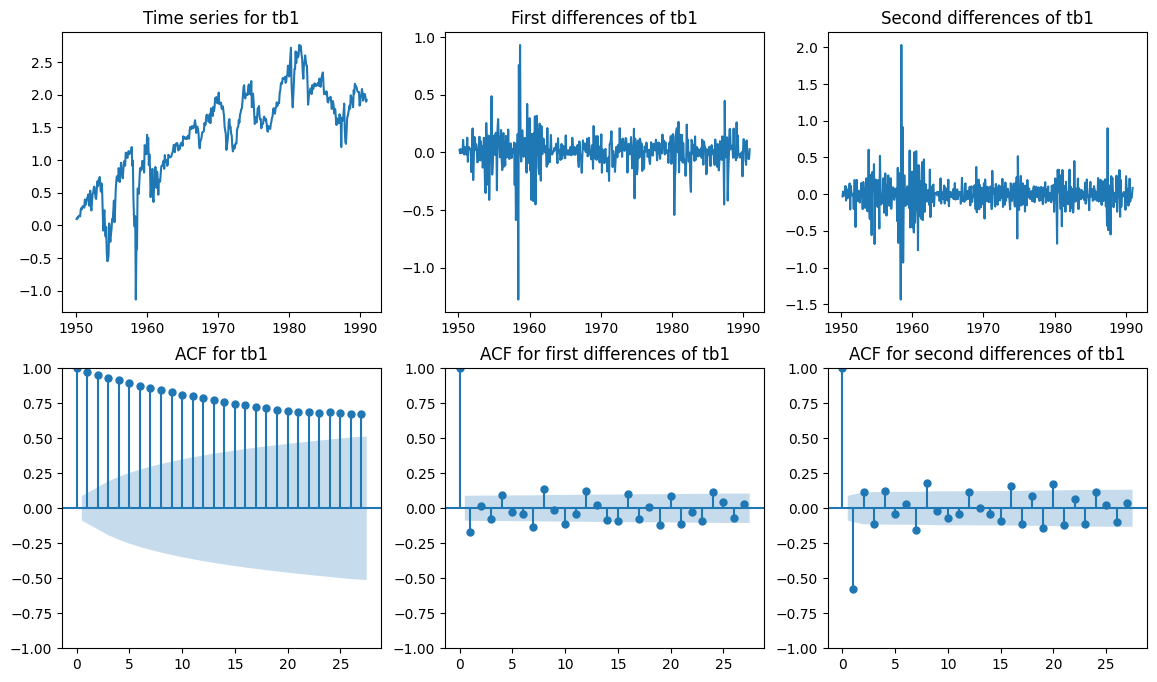

In [224]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

axs[0][0].plot(tb1);
axs[0][0].set_title('Time series for tb1');

axs[0][1].plot(tb1.diff().dropna());
axs[0][1].set_title('First differences of tb1');

axs[0][2].plot(tb1.diff().diff().dropna());
axs[0][2].set_title('Second differences of tb1');

tsaplots.plot_acf(tb1, ax=axs[1][0]);
axs[1][0].set_title('ACF for tb1');

tsaplots.plot_acf(tb1.diff().dropna(), ax=axs[1][1]);
axs[1][1].set_title('ACF for first differences of tb1');

tsaplots.plot_acf(tb1.diff().diff().dropna(), ax=axs[1][2]);
axs[1][2].set_title('ACF for second differences of tb1');

(b) AIC selects ARIMA(4, 1, 2), whereas BIC selects ARIMA(0, 1, 1) - we choose the simpler of the two models:

In [225]:
fit1 = pm.auto_arima(tb1, seasonal=False, information_criterion='aic')
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 259.906
Date:                Thu, 06 Apr 2023   AIC                           -505.813
Time:                        14:30:52   BIC                           -476.452
Sample:                             0   HQIC                          -494.282
                                - 491                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1955      0.037     -5.297      0.000      -0.268      -0.123
ar.L2         -0.8905      0.049    -18.161      0.000      -0.987      -0.794
ar.L3         -0.1994      0.029     -6.868      0.000      -0.256      -0.143
ar.L4          0.0777      0.038      2.041      0.041       0.003       0.152
ma.L1          0.0316      0.033      0.963      0.335      -0.033       0.096
ma.L2          0.9226      0.040     22.886      0.000       0.844       1.002
sigma2         0.0202      0.001     29.973      0.000       0.019       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4450.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
fit2 = pm.auto_arima(tb1, seasonal=False, information_criterion='bic')
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 244.477
Date:                Thu, 06 Apr 2023   AIC                           -484.955
Time:                        14:30:54   BIC                           -476.566
Sample:                             0   HQIC                          -481.660
                                - 491                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1692      0.024     -6.992      0.000      -0.217      -0.122
sigma2         0.0216      0.000     45.509      0.000       0.021       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4875.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(c)

In [228]:
resid = fit2.resid()

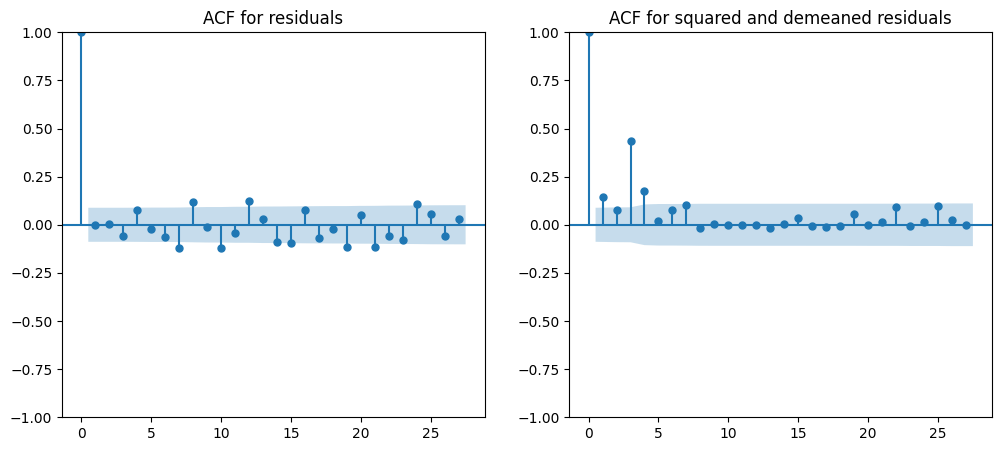

In [229]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

tsaplots.plot_acf(resid, ax=axs[0]);
axs[0].set_title('ACF for residuals');

tsaplots.plot_acf((resid - resid.mean()) ** 2, ax=axs[1]);
axs[1].set_title('ACF for squared and demeaned residuals');

The ACF of residuals suggests there might be some seasonality, whereas the ACF of squared residuals suggests volatility clustering.

#### Exercise 16

In [233]:
Ys = np.array([101.0, 99.5, 102.3])
phis = np.array([0.5, 0.1])
mu = 100.1

In [234]:
forecast_ar(Ys, phis, mu, 3)

array([101.14 , 100.84 , 100.574])

In [237]:
Ynp1 = mu + phis[0] * (Ys[-1] - mu) + phis[1] * (Ys[-2] - mu)
Ynp1

101.13999999999999

In [238]:
Ynp2 = mu + phis[0] * (Ynp1 - mu) + phis[1] * (Ys[-1] - mu)
Ynp2

100.83999999999999

In [239]:
Ynp3 = mu + phis[0] * (Ynp2 - mu) + phis[1] * (Ynp1 - mu)
Ynp3

100.574

#### Exercise 17

First, we show that for any $m$, if $E[Y_t] = \beta_0 + \beta_1 t + ... + \beta_m t^m = \sum_{i=0}^m \beta_i t^i$, then $E[\Delta Y_t] = \gamma + \gamma_1 t + ... + \gamma_{m-1} t^{m-1} = \sum_{i=0}^{m-1} \gamma_i t^i$:
$$E[\Delta Y_{t+1}] = E[Y_{t+1} - Y_t] = E[Y_{t+1}] - E[Y_t] = \sum_{i=0}^m \beta_i (t+1)^i -\sum_{i=0}^m \beta_i t^i = \sum_{i=0}^{m-1} \beta_i (t+1)^i + \beta_m (t+1)^m - \sum_{i=0}^{m-1} \beta_i t^i - \beta_m t^m \\
= \sum_{i=0}^{m-1} \beta_i (t+1)^i + \beta_m \sum_{j=0}^{m-1} {m \choose j} t^j + \beta_m t^m - \sum_{i=0}^{m-1} \beta_i t^i - \beta_m t^m 
= \sum_{i=0}^{m-1} \beta_i (t+1)^i + \beta_m \sum_{j=0}^{m-1} {m \choose j} t^j - \sum_{i=0}^{m-1} \beta_i t^i,$$
which is a polynomial in $t$ of order at most $(m-1)$.

Now we prove by induction in $d$ that if $E[E_t]$ is a polynomial of order $m$ in $t$, then $E[\Delta^d E_t]$ is a polynomial of order $(m-d)$ in $t$.

The base of induction (for $d=1$) has been proved above.

For the inductive step, suppose the statement holds for $d$, and so for $E[Y_t] = \beta_0 + \beta_1 t + ... + \beta_m t^m = \sum_{i=0}^m \beta_i t^i$ we have $E[\Delta^d Y_t] = \gamma + \gamma_1 t + ... + \gamma_{m-d} t^{m-d} = \sum_{i=0}^{m-d} \gamma_i t^i$.

Now
$$E[\Delta^{d+1} Y_{t+1}] = E[\Delta \Delta^d Y_{t+1}] = E[\Delta^d Y_{t+1} - \Delta^d Y_{t}] = E[\Delta^d Y_{t+1}] - E[\Delta^d Y_{t}] = \sum_{i=0}^{m-d} \gamma_i (t+1)^i - \sum_{i=0}^{m-d} \gamma_i t^i,$$

which, by the same logic as in the first proof above, is a polynomic of order $(m-d-1)$, as required.